In [1]:
import pandas as pd
import pickle 

# GET PARAMETERS
import os 
import sys

current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
    
import glob
from examples.train_model_on_k_fold_validation import load_configuration

import re
import pandas as pd

def split_col(col: str):
    # — Niveau 0 — #
    if col.startswith("VAR_"):
        level0 = "VAR"
        core = col[4:]                     # on coupe le préfixe 'VAR_'
    elif col.endswith("_complete_ds"):
        level0 = "Complete Dataset"
        core = col.replace("_complete_ds", "")
    else:
        level0 = "Mean K fold"
        core = col

    # — Niveau 1 & 2 — #
    # core ressemble maintenant à 'mse_h1', 'mae_h4', …
    metric, horizon = re.match(r"(.*?)_h(\d)", core).groups()
    level1 = metric.upper()               # MSE / MAE / MAPE
    level2 = int(horizon)                 # 1, 2, 3 ou 4

    return level0, level1, level2

Training and Hyper-parameter tuning with Ray is not possible


/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
args_i

{'args': {'model_name': 'STAEformer',
  'dataset_names': ['subway_in', 'calendar'],
  'dataset_for_coverage': ['subway_in', 'netmob_POIs'],
  'calendar_types': ['dayofweek', 'timeofday'],
  'embedding_calendar_types': ['dayofweek', 'hour'],
  'device': device(type='cuda'),
  'optimizer': 'adamw',
  'single_station': False,
  'loss_function_type': 'MSE',
  'epsilon_clustering': 0.05,
  'freq': '15min',
  'minmaxnorm': True,
  'standardize': False,
  'learnable_adj_matrix': False,
  'learnable_adj_top_k': 8,
  'learnable_adj_embd_dim': 8,
  'contextual_positions': {'calendar_dayofweek': 0, 'calendar_timeofday': 1},
  'quick_vision': False,
  'netmob_transfer_mode': 'DL',
  'evaluate_complete_ds': True,
  'train_valid_test_split_method': 'similar_length_method',
  'set_spatial_units': None,
  'hp_tuning_on_first_fold': True,
  'keep_best_weights': False,
  'num_workers': 0,
  'persistent_workers': False,
  'pin_memory': True,
  'prefetch_factor': 2,
  'drop_last': False,
  'mixed_precisio

In [3]:
args_i

{'args': {'model_name': 'STAEformer',
  'dataset_names': ['subway_in', 'netmob_POIs', 'calendar'],
  'dataset_for_coverage': ['subway_in', 'netmob_POIs'],
  'calendar_types': ['dayofweek', 'timeofday'],
  'embedding_calendar_types': ['dayofweek', 'hour'],
  'device': device(type='cuda'),
  'optimizer': 'adamw',
  'single_station': False,
  'loss_function_type': 'MSE',
  'epsilon_clustering': 0.05,
  'freq': '15min',
  'minmaxnorm': True,
  'standardize': False,
  'learnable_adj_matrix': False,
  'learnable_adj_top_k': 8,
  'learnable_adj_embd_dim': 8,
  'contextual_positions': {'calendar_dayofweek': 0,
   'calendar_timeofday': 1,
   'netmob_POIs': 2},
  'quick_vision': False,
  'netmob_transfer_mode': 'DL',
  'evaluate_complete_ds': True,
  'train_valid_test_split_method': 'similar_length_method',
  'set_spatial_units': None,
  'hp_tuning_on_first_fold': True,
  'keep_best_weights': False,
  'num_workers': 0,
  'persistent_workers': False,
  'pin_memory': True,
  'prefetch_factor': 2,


In [9]:
import matplotlib.pyplot as plt
from dl_models.full_model import full_model
from examples.train_and_visu_non_recurrent import evaluate_config,train_the_config,get_ds
from argparse import Namespace
dirname = '~/prediction-validation/save/K_fold_validation/training_with_HP_tuning'

# STAEformer 300 epoch 200 trials, search space réduit avec analyse des distribution d'HP précédente. Calendar tod = 0,dow = 0
if True:
    pattern_trial_ids = ['subway_in_calendar_STAEformer_MSELoss_2025_05_15_18_45_29824',
                        'subway_in_netmob_POIs_calendar_STAEformer_MSELoss_2025_05_16_00_05_76700',
                        'subway_in_netmob_POIs_calendar_STAEformer_MSELoss_2025_05_16_04_43_18329',
                        'subway_in_netmob_POIs_calendar_STAEformer_MSELoss_2025_05_16_09_21_42607',
                        'subway_in_netmob_POIs_calendar_STAEformer_MSELoss_2025_05_16_14_50_87178',
                        'subway_in_netmob_POIs_calendar_STAEformer_MSELoss_2025_05_16_19_35_79576',
                        'subway_in_netmob_POIs_calendar_STAEformer_MSELoss_2025_05_17_01_05_60051',
                        'subway_in_netmob_POIs_calendar_STAEformer_MSELoss_2025_05_17_04_54_32707'
                        ]

# STAEformer 500 epoch 200 trials, search space reduit. tod = 4, dow = 4
if False:
     pattern_trial_ids = ['subway_in_calendar_STAEformer_MSELoss_2025_05_15_10_08_21638',
                          'subway_in_netmob_POIs_calendar_STAEformer_MSELoss_2025_05_15_04_22_5433']

# STAEformer 500 epoch 500 trials, search space reduit. Calendar tod = 0,dow = 0
if False:
    pattern_trial_ids  = ['subway_in_STGCN_MSELoss_2025_05_13_03_09_7326',
                        'subway_in_calendar_embedding_STGCN_MSELoss_2025_05_13_22_43_80647',

                        'subway_in_netmob_POIs_calendar_STAEformer_MSELoss_2025_05_08_19_53_13965',
                        'subway_in_netmob_POIs_calendar_STAEformer_MSELoss_2025_05_09_19_28_36371',
                        'subway_in_netmob_POIs_calendar_STAEformer_MSELoss_2025_05_10_07_36_27059',
                        'subway_in_netmob_POIs_calendar_STAEformer_MSELoss_2025_05_10_19_28_4752',
                        'subway_in_netmob_POIs_calendar_STAEformer_MSELoss_2025_05_11_07_23_58546',
                        'subway_in_netmob_POIs_calendar_STAEformer_MSELoss_2025_05_11_17_51_55895',
                        'subway_in_netmob_POIs_calendar_STAEformer_MSELoss_2025_05_12_04_10_74908',

                        'subway_in_calendar_STAEformer_MSELoss_2025_05_09_07_12_41998']

trial_csv = []
for pattern_trial_id in pattern_trial_ids:
        trial_csv_i = glob.glob(os.path.expanduser(f"{dirname}/METRICS_{pattern_trial_id}*.csv"))
        trial_csv = trial_csv + trial_csv_i



saved_models = pickle.load(open(os.path.expanduser(f"{dirname}/best_models/model_args.pkl"),'rb'))
df_test_metrics = pd.DataFrame()
for csv_i in trial_csv:
    trial_id = csv_i.split('METRICS_')[-1][:-4]
    saved_folds = [saved_fold for saved_fold in saved_models['model'].keys() if trial_id in saved_fold]

    args_i = saved_models['model'][saved_folds[0]]



    dataset_names = args_i['args']['dataset_names']
    if 'netmob_POIs' in dataset_names:
        NetMob_selected_apps = ', '.join(args_i['args']['NetMob_selected_apps'])
    else:
        NetMob_selected_apps = None

    df_test_metrics_i = pd.read_csv(csv_i,index_col = 0)
    df_test_metrics_i['trial_id'] = NetMob_selected_apps
    df_test_metrics_i['datasets'] = ', '.join(dataset_names)

    # Print Model size: 
    args_init = args_i['args'].copy()
    args_init.pop('time_step_per_hour')
    ds,args_i_bis,trial_id,save_folder,df_loss = get_ds(modification={},args_init=Namespace(**args_init),fold_to_evaluate=[0])
    model = full_model(ds, args_i_bis).to(args_i_bis.device)
    print(df_test_metrics_i['datasets'],df_test_metrics_i['trial_id'])
    if 'STGCN' in csv_i:
         df_test_metrics_i['model'] = 'STGCN'
    elif 'STAEformer' in csv_i:
         df_test_metrics_i['model'] = 'STAEformer'
    df_test_metrics_i = pd.DataFrame(df_test_metrics_i.loc['test']).T.set_index(['model','datasets','trial_id'])
    df_test_metrics = pd.concat([df_test_metrics, df_test_metrics_i], axis = 0)

    # Plot df losses:
    if False:
        df_losses = pd.read_csv(os.path.expanduser(f"{dirname}/Losses_{trial_id}.csv"),index_col = 0)
        valid_columns = [c for c in df_losses.columns if ('valid' in c) and not ('fcomplete' in c)]
        title = NetMob_selected_apps if NetMob_selected_apps is not None else 'Reference Subway-in Only'
        ax = df_losses[valid_columns].iloc[100:].plot(title= title)
        ax.set_ylim(0.00250,0.0065)
    

for agg in ['','_complete_ds']:
    for metric in ["mse", "mae", "mape",'mase']:
        # Print metrics on K-fold:
        columns = [f"{metric}_h{h}{agg}" for h in range(1, 5)]
        display(df_test_metrics[columns])

----------------------------------------
Loading the Complete Dataset for K-fold splitting
Coverage Period: 7392 elts between 2019-03-16 00:00:00 and 2019-05-31 23:45:00
Invalid dates within this fold: 776

>>>Tackle Target dataset: subway_in
   Load data from: //home/rrochas/../../data/rrochas/prediction_validation/subway_in/subway_in.csv


TypeError: dataset.DataSet() got multiple values for keyword argument 'time_step_per_hour'

In [11]:

args_i['args']['time_step_per_hour']

KeyError: 'time_step_per_hour'

In [200]:
import numpy as np
def format_latex_table(df_i, metric_name="MASE", label="tab:resultats_MASE"):
    # Récupération des données
    horizons = df_i.columns.levels[2]
    mae_cols = [(metric_name, 'metric', h) for h in horizons]
    gain_cols = [(metric_name, 'gain', h) for h in horizons]

    # Ligne de référence = première ligne
    reference = df_i.iloc[0][mae_cols].values

    # Corps du tableau
    rows = []
    mae_values_only = df_i[mae_cols]
    min_per_col = mae_values_only.min()

    reference_fmt = ['\\textbf{%.2f}' % v if v == min_per_col.iloc[i] else '%.2f' % v for i, v in enumerate(reference)]


    for idx, row in df_i.iloc[1:].iterrows():
        mae_vals = row[mae_cols].values
        gain_vals = row[gain_cols].values

        formatted_row = []
        for i, (mae, gain) in enumerate(zip(mae_vals, gain_vals)):
            if i == 0 and gain == 0:
                if mae == min_per_col[mae_cols[i]]:
                    formatted_row.append('\\textbf{%.2f}' % mae)
                else:
                    formatted_row.append('%.2f' % mae)

            else:
                sign = "+" if gain > 0 else ""
                if mae == min_per_col[mae_cols[i]]:
                    formatted_row.append('\\textbf{%.2f} (%s%.1f\\%%)' % (mae, sign, gain))
                else:
                    formatted_row.append('%.2f (%s%.1f\\%%)' % (mae, sign, gain))
                    

        # Concaténer les 3 niveaux d'index, en échappant les underscores
        index_parts = [str(part.replace("subway_in", ""))  if (isinstance(part,str) and 'subway_in' in part) else part for part in idx]
        index_parts = [part for part in index_parts if part != ""]
        index_parts = [str(part).replace("_", "\\_") for part in index_parts  if (part is not np.nan)]
        
        display_name = ", ".join(index_parts)

        rows.append(display_name + " & " + " & ".join(formatted_row) + " \\\\")

    # Construction finale
    latex = f"""\\scalebox{{0.6}}{{%
            \\begin{{table}}[htbp]
            \\centering
            \\scriptsize
            \\setlength{{\\tabcolsep}}{{2pt}} %% Réduit l'espace entre les colonnes
            \\renewcommand{{\\arraystretch}}{{1.2}} %% Espacement vertical entre lignes
            \\begin{{tabular}}{{l|| *{{4}}{{c@{{\\hskip 4pt}}}} ||}}
            \\toprule
            & \\multicolumn{{4}}{{c||}}{{{{{label}}}}} \\\\
            & {' & '.join([f'h{h}' for h in horizons])} \\\\
            \\midrule
            Reference & {' & '.join(reference_fmt)} \\\\
            \\midrule
            """ + "\n".join(rows) + f"""
            \\bottomrule
            \\end{{tabular}}
            \\label{{{label}}}
            \\end{{table}}
            }}"""


    return latex


for column_type in ['complete', 'kfold']:
    for metric in ['mae','mse','mape','mase']:
        if column_type == 'complete':
            column_list = [col for col in df_test_metrics.columns if (metric in col and 'complete' in col and not 'VAR' in col)]
            label = f"tab:resultats {metric.upper()} complete"
        else:
            column_list = [col for col in df_test_metrics.columns if (metric in col and not 'complete' in col and not 'VAR' in col)]
            label = f"tab:resultats {metric.upper()} kfold"

        df_i = df_test_metrics[column_list].copy()
        reference = df_i.loc[('STAEformer','subway_in, calendar',np.nan)]
        for c in df_i.columns:
            locals()[f"gain_{c}"] = 100*((df_i[c] - reference[c]) / reference[c])
        for c in df_i.columns:
            df_i[f"gain_{c}"] = locals()[f"gain_{c}"]
        df_i.columns = pd.MultiIndex.from_product([[metric],['metric','gain'],[horizon for horizon in range(1,5)]], names=['metric', 'value','horizon'])
        df_i = pd.concat([df_i.tail(1), df_i.iloc[:-1]])

        # Re-organize columns
        new_columns = []
        for metric_name in df_i.columns.levels[0]:
            for h in df_i.columns.levels[2]:  # horizon
                new_columns.append((metric_name, 'metric', h))
                new_columns.append((metric_name, 'gain', h))
        df_i = df_i[new_columns]
            
        latex = format_latex_table(df_i, metric_name=metric, label=label)

        print(latex)


\scalebox{0.6}{%
            \begin{table}[htbp]
            \centering
            \scriptsize
            \setlength{\tabcolsep}{2pt} %% Réduit l'espace entre les colonnes
            \renewcommand{\arraystretch}{1.2} %% Espacement vertical entre lignes
            \begin{tabular}{l|| *{4}{c@{\hskip 4pt}} ||}
            \toprule
            & \multicolumn{4}{c||}{{tab:resultats MAE complete}} \\
            & h1 & h2 & h3 & h4 \\
            \midrule
            Reference & 21.43 & 23.23 & 24.18 & 24.42 \\
            \midrule
            STGCN & 21.37 (-0.3\%) & 22.73 (-2.1\%) & 23.80 (-1.6\%) & 24.46 (+0.2\%) \\
STGCN, , calendar\_embedding & \textbf{21.08} (-1.6\%) & \textbf{21.93} (-5.6\%) & \textbf{22.75} (-5.9\%) & \textbf{23.31} (-4.5\%) \\
STAEformer, , netmob\_POIs, calendar, Web\_Weather & 21.54 (+0.5\%) & 23.28 (+0.3\%) & 23.80 (-1.6\%) & 24.42 (-0.0\%) \\
STAEformer, , netmob\_POIs, calendar, Deezer & 22.05 (+2.9\%) & 23.57 (+1.5\%) & 23.94 (-1.0\%) & 24.18 (-1.0\%) \\
S

In [ ]:
import numpy as np
df_test_metrics = df_test_metrics.reset_index()
mse_cols = ['mse_h1', 'mse_h2', 'mse_h3', 'mse_h4']
mae_cols = ['mae_h1', 'mae_h2', 'mae_h3', 'mae_h4']
mase_cols = ['mase_h1_complete_ds', 'mase_h2_complete_ds', 'mase_h3_complete_ds', 'mase_h4_complete_ds']
mape_cols = ['mape_h1', 'mape_h2', 'mape_h3', 'mape_h4']

all_metrics = {
    'RMSE': mse_cols,
    'MAE': mae_cols,
    'MASE': mase_cols,
    'MAPE': mape_cols
}
#df_test_metrics =df_test_metrics.reset_index()
# --- 3. Identifier la référence (ligne avec trial_id NaN)
reference = df_test_metrics[df_test_metrics['trial_id'].isna()].squeeze()

# --- 4. Calculer les gains et organiser les données
rows = []
index_names = []

# Tackle ref
values = []
name = 'Reference'
for metric, cols in all_metrics.items():
    for h, col in zip(['h1', 'h2', 'h3', 'h4'], cols):
        if metric == 'RMSE':
            ref_val = np.sqrt(reference[col])
        else:
            ref_val = reference[col]
        values.append(f"{ref_val:.2f}")
rows.append(values)
index_names.append(name)

# Tackle all other trials:
for _, row in df_test_metrics.iterrows():
    name = row['trial_id']  # datasets only
    values = []
    if pd.isna(name):
        continue  # On ne veut pas inclure la référence dans la sortie finale
    else:
        for metric, cols in all_metrics.items():
            for h, col in zip(['h1', 'h2', 'h3', 'h4'], cols):
                if metric == 'RMSE':
                    val = np.sqrt(row[col])
                    ref_val = np.sqrt(reference[col])
                else:
                    val = row[col]
                    ref_val = reference[col]
                gain = 100 * (ref_val - val) / ref_val if pd.notna(ref_val) else np.nan
                values.append(f"{val:.2f} ({gain:.1f}\%)")
    
    rows.append(values)
    index_names.append(name)

# --- 5. Construire le MultiIndex des colonnes
arrays = []
for metric, cols in all_metrics.items():
    for h in ['h1', 'h2', 'h3', 'h4']:
        arrays.append((metric, h))

columns = pd.MultiIndex.from_tuples(arrays)

# --- 6. Créer le DataFrame final
latex_df = pd.DataFrame(rows, columns=columns, index=index_names)

# --- 7. Exporter en LaTeX
latex_code = latex_df.to_latex(multicolumn=True, multirow=True, escape=False)

print(latex_code)

\begin{tabular}{lllllllllllllllll}
\toprule
 & \multicolumn{4}{r}{RMSE} & \multicolumn{4}{r}{MAE} & \multicolumn{4}{r}{MASE} & \multicolumn{4}{r}{MAPE} \\
 & h1 & h2 & h3 & h4 & h1 & h2 & h3 & h4 & h1 & h2 & h3 & h4 & h1 & h2 & h3 & h4 \\
\midrule
Reference & 38.03 & 41.45 & 44.28 & 46.55 & 22.41 & 23.78 & 24.94 & 25.93 & 0.67 & 0.71 & 0.75 & 0.76 & 31.53 & 33.34 & 36.20 & 42.87 \\
\bottomrule
\end{tabular}



<Axes: >

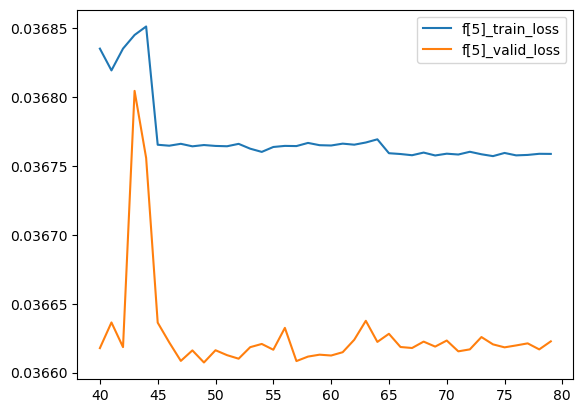

In [ ]:
dirname = '~/prediction-validation/save/K_fold_validation/training_wo_HP_tuning'
pattern_trial_ids = ['DSTRformer_PeMS08_calendar_fold_5_epochs_80']
pd.read_csv(os.path.expanduser(f"{dirname}/{pattern_trial_ids[0]}/Losses_{pattern_trial_ids[0]}.csv"),index_col = 0).iloc[40:].plot()

In [47]:
pattern_trial_ids = ['subway_in_subway_out_calendar_STAEformer_MSELoss_2025_05_06_02_00_73032']


df_results = pd.DataFrame()
for pattern_trial_id in pattern_trial_ids:
    trial_csv = glob.glob(os.path.expanduser(f"~/prediction-validation/save/K_fold_validation/training_with_HP_tuning/{trial_id}/METRICS_s*.csv"))
    for csv in trial_csv:
        df_results_i = pd.read_csv(csv,index_col = 0)
        df_results_i['trial_id'] = csv.split(f"{trial_id}")[-1].split(".")[0]
        df_results = pd.concat([df_results, df_results_i], axis = 0)
    df_results = df_results.loc['test']
    df_results.set_index('trial_id', inplace = True)
    df_results.iloc[0]



    columns = [f"{metric}_h{h}" for metric in ["mse", "mae", "mape",'mase'] for h in range(1, 5)]
    columns_complete = [f"{metric}_h{h}_complete_ds" for metric in ["mse", "mae", "mape",'mase'] for h in range(1, 5)]
    columns_var = [f"VAR_{metric}_h{h}" for metric in ["mse", "mae", "mape",'mase'] for h in range(1, 5)]
    display(df_results[columns])
    display(df_results[columns_var])
    display(df_results[columns_complete])


,mse_h1,mse_h2,mse_h3,mse_h4,mae_h1,mae_h2,mae_h3,mae_h4,mape_h1,mape_h2,mape_h3,mape_h4,mase_h1,mase_h2,mase_h3,mase_h4
trial_id,,,,,,,,,,,,,,,,
naiv,1345.604321,1588.977466,1777.586719,1834.070508,21.394479,23.073368,24.306406,24.477066,27.439230,30.266537,35.138156,38.116521,0.698648,0.754644,0.795296,0.797542
Google_Maps_Deezer,1422.287988,1657.943115,1817.760596,1884.087842,22.084005,23.597522,24.564458,24.899227,28.298946,30.841166,33.256695,36.374311,0.721766,0.771839,0.803424,0.811451
DENOISE_SVG_Google_Maps_Deezer,1417.863135,1637.283447,1788.401611,1879.481079,21.899223,23.300196,24.397657,25.128160,27.291971,29.395881,32.522723,38.294285,0.715902,0.762504,0.798183,0.819565
DENOISE_median_Google_Maps_Deezer,1381.109351,1636.823926,1812.275708,1915.392651,21.543419,23.257841,24.441046,25.160733,26.534287,30.111515,32.912366,36.244702,0.703749,0.760431,0.799194,0.819686
DENOISE_mean_centered3_Google_Maps_Deezer,1410.965430,1618.559717,1795.405469,1851.956055,21.909443,23.287270,24.386412,24.698060,26.918268,30.215764,33.281694,36.421446,0.716123,0.761366,0.797241,0.804358
DENOISE_mean_causal2_Google_Maps_Deezer,1462.591504,1665.393066,1863.891602,1920.705737,22.207747,23.639949,25.010154,25.431540,27.695857,30.342436,34.167640,38.425968,0.725919,0.773148,0.818041,0.828477
DENOISE_mean_centered3_Google_Maps,1393.870117,1645.296729,1779.244727,1880.041211,21.815290,23.355873,24.202024,24.899231,27.648788,30.462630,33.032779,37.865837,0.712821,0.763665,0.790843,0.810466
DENOISE_mean_causal2_Google_Maps,1374.286133,1642.954224,1787.069702,1840.510522,21.619696,23.415160,24.257362,24.719535,27.806916,30.654382,32.911664,36.248767,0.706171,0.765153,0.792486,0.804166
DENOISE_mean_causal2_Deezer,1400.540771,1633.354028,1772.158154,1822.198462,21.768152,23.266425,24.201241,24.576617,28.047028,29.732226,33.985275,38.747062,0.711545,0.760768,0.790996,0.800024


,VAR_mse_h1,VAR_mse_h2,VAR_mse_h3,VAR_mse_h4,VAR_mae_h1,VAR_mae_h2,VAR_mae_h3,VAR_mae_h4,VAR_mape_h1,VAR_mape_h2,VAR_mape_h3,VAR_mape_h4,VAR_mase_h1,VAR_mase_h2,VAR_mase_h3,VAR_mase_h4
trial_id,,,,,,,,,,,,,,,,
naiv,677.595174,13255.474706,51745.871866,71062.293615,0.083206,0.786353,2.582076,2.539596,15.181114,30.194111,62.204747,46.060764,0.001718,0.004408,0.008531,0.008388
Google_Maps_Deezer,3614.802160,28257.004565,54995.942540,89237.345427,0.371851,1.319594,2.286495,3.176289,23.776035,41.227372,54.508443,45.372761,0.003055,0.005868,0.008028,0.009526
DENOISE_SVG_Google_Maps_Deezer,11106.688048,41875.986492,60159.533100,77154.468440,0.512955,1.613693,2.792199,4.555837,17.299020,17.846238,29.171906,48.310860,0.003403,0.006357,0.009011,0.012288
DENOISE_median_Google_Maps_Deezer,2072.423126,17591.637300,47738.507527,45697.020145,0.129250,0.715488,2.082827,2.458250,14.534142,32.263454,36.771419,35.792570,0.002152,0.004223,0.007428,0.008205
DENOISE_mean_centered3_Google_Maps_Deezer,2536.236091,10907.005029,31054.655751,40665.976456,0.321810,0.598295,1.427408,1.685181,14.350970,18.228515,33.601773,32.286656,0.003013,0.004005,0.006111,0.006627
DENOISE_mean_causal2_Google_Maps_Deezer,7982.285368,27518.671173,59268.364942,76871.536072,0.775461,1.568932,3.507972,4.986476,19.848030,25.808073,41.272743,48.783408,0.003666,0.005632,0.009024,0.010569
DENOISE_mean_centered3_Google_Maps,4665.345814,26785.432421,39165.215818,45718.248124,0.221803,0.773154,1.337725,1.663590,18.310239,22.197588,30.317966,20.176292,0.002648,0.004484,0.005715,0.006258
DENOISE_mean_causal2_Google_Maps,2604.441706,8182.487105,22084.158022,21988.722079,0.108846,0.331623,0.868345,1.064542,16.226555,13.146510,17.502535,13.897075,0.002075,0.002962,0.004595,0.004406
DENOISE_mean_causal2_Deezer,9645.385618,24766.535523,37723.214113,40654.070704,0.427557,0.832116,1.333368,1.697650,12.478054,15.181103,26.817857,29.610014,0.003189,0.004389,0.005700,0.006104


,mse_h1_complete_ds,mse_h2_complete_ds,mse_h3_complete_ds,mse_h4_complete_ds,mae_h1_complete_ds,mae_h2_complete_ds,mae_h3_complete_ds,mae_h4_complete_ds,mape_h1_complete_ds,mape_h2_complete_ds,mape_h3_complete_ds,mape_h4_complete_ds,mase_h1_complete_ds,mase_h2_complete_ds,mase_h3_complete_ds,mase_h4_complete_ds
trial_id,,,,,,,,,,,,,,,,
naiv,1345.343384,1532.730957,1656.238647,1679.957031,21.007812,22.299263,23.111015,23.329325,23.958414,25.476831,27.946386,33.757000,0.656152,0.698672,0.725231,0.729407
Google_Maps_Deezer,1382.593384,1593.072632,1716.419434,1730.194336,21.384956,22.739759,23.484522,23.776117,23.990509,25.536654,27.222332,31.954119,0.667905,0.711324,0.736934,0.743129
DENOISE_SVG_Google_Maps_Deezer,1334.215698,1465.818481,1603.241943,1593.478394,21.003872,21.822426,22.873396,22.844255,23.540331,25.433815,29.014328,32.058846,0.656009,0.683494,0.717432,0.714054
DENOISE_median_Google_Maps_Deezer,1358.299072,1583.252197,1639.775879,1694.180542,21.184929,22.550137,22.899225,23.341288,23.397223,25.739395,27.048164,30.534554,0.661692,0.706417,0.718441,0.729612
DENOISE_mean_centered3_Google_Maps_Deezer,1420.564575,1620.904663,1755.705811,1751.415405,21.430737,22.756493,23.533171,23.716217,23.629463,25.918842,27.705912,30.484819,0.669348,0.712859,0.738374,0.741473
DENOISE_mean_causal2_Google_Maps_Deezer,1379.125488,1525.740601,1694.507935,1717.796265,21.232391,22.320284,23.248169,23.407368,23.372911,24.940681,27.371239,31.419796,0.663160,0.699146,0.729412,0.731714
DENOISE_mean_centered3_Google_Maps,1353.662720,1548.823975,1627.322388,1693.367188,21.506502,22.638441,22.953485,23.597328,26.264938,26.908281,28.208689,34.627125,0.671608,0.708762,0.720117,0.737276
DENOISE_mean_causal2_Google_Maps,1390.261963,1609.225586,1713.997681,1739.596313,21.370916,22.789740,23.419163,23.739880,23.555809,25.590324,28.147814,31.952116,0.667175,0.713996,0.734853,0.742161
DENOISE_mean_causal2_Deezer,1321.487915,1518.457886,1672.542236,1652.425537,21.074242,22.313425,23.416683,23.355408,24.936462,25.862253,30.215332,35.468166,0.658117,0.698517,0.734808,0.730254


In [ ]:
trial_id = 'subway_in_subway_out_STGCN_MSELoss_2025_05_05_12_46_99927'
trial_csv = glob.glob(os.path.expanduser(f"~/prediction-validation/save/K_fold_validation/training_with_HP_tuning/METRICS_{trial_id}*.csv"))
df_results = pd.read_csv(trial_csv[0],index_col = 0)
df_results = df_results.loc[['test']]

display(df_results[columns])
display(df_results[columns_var])
display(df_results[columns_complete])

,mse_h1,mse_h2,mse_h3,mse_h4,mae_h1,mae_h2,mae_h3,mae_h4,mape_h1,mape_h2,mape_h3,mape_h4,mase_h1,mase_h2,mase_h3,mase_h4
test,1392.330566,1579.048804,1705.066284,1808.663794,22.340922,23.245601,23.828046,24.409001,34.831975,36.101426,38.062737,44.017339,0.731957,0.761787,0.780391,0.7963


,VAR_mse_h1,VAR_mse_h2,VAR_mse_h3,VAR_mse_h4,VAR_mae_h1,VAR_mae_h2,VAR_mae_h3,VAR_mae_h4,VAR_mape_h1,VAR_mape_h2,VAR_mape_h3,VAR_mape_h4,VAR_mase_h1,VAR_mase_h2,VAR_mase_h3,VAR_mase_h4
test,20014.874088,37430.08443,52021.587979,72813.150491,2.706816,3.398028,4.28655,4.832366,141.751408,169.23888,192.385825,199.660554,0.008535,0.009967,0.011566,0.012417


,mse_h1_complete_ds,mse_h2_complete_ds,mse_h3_complete_ds,mse_h4_complete_ds,mae_h1_complete_ds,mae_h2_complete_ds,mae_h3_complete_ds,mae_h4_complete_ds,mape_h1_complete_ds,mape_h2_complete_ds,mape_h3_complete_ds,mape_h4_complete_ds,mase_h1_complete_ds,mase_h2_complete_ds,mase_h3_complete_ds,mase_h4_complete_ds
test,1318.588745,1495.361328,1602.558838,1695.67749,20.998423,21.916164,22.407064,22.996902,25.266808,26.232067,27.857437,34.304722,0.655792,0.686473,0.70306,0.719016


In [ ]:
trial_id = 'subway_in_subway_out_ASTGCN_MSELoss_2025_05_04_23_19_52993'
trial_csv = glob.glob(os.path.expanduser(f"~/prediction-validation/save/K_fold_validation/training_with_HP_tuning/METRICS_{trial_id}*.csv"))
df_results = pd.read_csv(trial_csv[0],index_col = 0)
df_results = df_results.loc[['test']]

display(df_results[columns])
display(df_results[columns_var])
display(df_results[columns_complete])

,mse_h1,mse_h2,mse_h3,mse_h4,mae_h1,mae_h2,mae_h3,mae_h4,mape_h1,mape_h2,mape_h3,mape_h4,mase_h1,mase_h2,mase_h3,mase_h4
test,1452.832813,1692.383643,1862.799658,2051.216943,22.430046,24.044086,25.188047,26.304317,28.55376,31.148911,34.903407,39.336251,0.732548,0.785246,0.822601,0.855982


,VAR_mse_h1,VAR_mse_h2,VAR_mse_h3,VAR_mse_h4,VAR_mae_h1,VAR_mae_h2,VAR_mae_h3,VAR_mae_h4,VAR_mape_h1,VAR_mape_h2,VAR_mape_h3,VAR_mape_h4,VAR_mase_h1,VAR_mase_h2,VAR_mase_h3,VAR_mase_h4
test,4971.253284,15789.841646,47946.1778,132709.355081,0.537226,1.022465,3.090202,6.194528,12.150291,11.745442,17.292491,11.342211,0.002389,0.003227,0.006746,0.010765


,mse_h1_complete_ds,mse_h2_complete_ds,mse_h3_complete_ds,mse_h4_complete_ds,mae_h1_complete_ds,mae_h2_complete_ds,mae_h3_complete_ds,mae_h4_complete_ds,mape_h1_complete_ds,mape_h2_complete_ds,mape_h3_complete_ds,mape_h4_complete_ds,mase_h1_complete_ds,mase_h2_complete_ds,mase_h3_complete_ds,mase_h4_complete_ds
test,1454.467163,1671.894043,1726.474121,1815.479004,22.344828,24.024408,24.044119,24.608419,26.170736,29.802191,30.980957,36.431179,0.697901,0.752245,0.754474,0.76946


In [ ]:
trial_id = 'subway_in_subway_out_calendar_STGformer_MSELoss_2025_05_04_12_18_5656'

trial_csv = glob.glob(os.path.expanduser(f"~/prediction-validation/save/K_fold_validation/training_with_HP_tuning/METRICS_{trial_id}*.csv"))
df_results = pd.read_csv(trial_csv[0],index_col = 0)
df_results = df_results.loc[['test']]

display(df_results[columns])
display(df_results[columns_var])
display(df_results[columns_complete])

,mse_h1,mse_h2,mse_h3,mse_h4,mae_h1,mae_h2,mae_h3,mae_h4,mape_h1,mape_h2,mape_h3,mape_h4,mase_h1,mase_h2,mase_h3,mase_h4
test,1351.289355,1655.435083,1891.91377,2091.590625,21.582214,23.485438,24.944067,26.064475,27.367403,30.253724,33.168578,38.265693,0.705618,0.768642,0.816983,0.851306


,VAR_mse_h1,VAR_mse_h2,VAR_mse_h3,VAR_mse_h4,VAR_mae_h1,VAR_mae_h2,VAR_mae_h3,VAR_mae_h4,VAR_mape_h1,VAR_mape_h2,VAR_mape_h3,VAR_mape_h4,VAR_mase_h1,VAR_mase_h2,VAR_mase_h3,VAR_mase_h4
test,12089.890651,70192.134245,169899.244887,403274.198366,1.169439,3.952598,8.903337,17.170348,14.371341,17.845063,29.976989,60.335455,0.004105,0.008818,0.016689,0.027538


,mse_h1_complete_ds,mse_h2_complete_ds,mse_h3_complete_ds,mse_h4_complete_ds,mae_h1_complete_ds,mae_h2_complete_ds,mae_h3_complete_ds,mae_h4_complete_ds,mape_h1_complete_ds,mape_h2_complete_ds,mape_h3_complete_ds,mape_h4_complete_ds,mase_h1_complete_ds,mase_h2_complete_ds,mase_h3_complete_ds,mase_h4_complete_ds
test,1296.697754,1480.098145,1634.836548,1681.844727,20.817446,21.974644,22.783855,23.108908,22.70046,25.791559,28.275496,31.802469,0.650265,0.688465,0.714566,0.722391
